In [1]:
from PIL import Image, ImageDraw
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import numpy as np
import pandas as pd
from time import time
import sys, os
import glob

from models.mtcnn import MTCNN, fixed_image_standardization

In [2]:
TRAIN_PATH = "./data/train/"
TEST_PATH  = "./data/test/"

In [3]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.max_memory_allocated(device='cuda'))
print(torch.cuda.empty_cache())

1.1.0
10.0
7401
True
1
0
None


In [4]:
trans = transforms.Compose([
    transforms.Resize(512)
])

In [5]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, transforms=None):
        super().__init__()
        self.root_dir = root_dir
        self.transforms = transforms
        self.samples = os.listdir(self.root_dir)
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_file = self.samples[idx]

        image = Image.open(os.path.join(self.root_dir, img_file))
        width, height = image.size
        if self.transforms:
            image = self.transforms(image)
            
        return image, img_file, width, height

In [18]:
dataset = ImageDataset(os.path.join(TEST_PATH, 'images'), transforms=trans)

In [7]:
mtcnn_pt = MTCNN(device=torch.device('cpu'))

In [19]:
list_coord_obj = []
for idx, (img, img_file, width, height) in enumerate(dataset):
    print(idx)    
    width_scale, height_scale = img.size
    boxes, probs, points = mtcnn_pt.detect(img, landmarks=True)
    if boxes is None:
        print(img_file)
        continue
    boxes = boxes.tolist()
    points = points.tolist()
    for id_box, box in enumerate(boxes):
        row = []
        row = [img_file, width, height, width_scale, height_scale]
        row.append(id_box)
        row += box
        for landmarks in points[id_box]:
            row += landmarks
        list_coord_obj.append(row)    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [20]:
df = pd.DataFrame(list_coord_obj)

In [21]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,296814969_3.jpg,846,846,512,512,0,-163.926163,136.748535,59.203026,392.848755,-87.683479,251.366211,7.742966,245.364655,-37.941895,289.454529,-91.050735,327.948242,7.268028,321.540771
1,296814969_3.jpg,846,846,512,512,1,174.199463,117.195930,340.578430,335.628632,233.735458,207.822052,305.950256,200.907379,284.151367,254.243073,246.754974,288.320526,308.156525,279.032867
2,2968560214_1.jpg,683,1024,512,767,0,105.508743,68.205978,564.507080,656.191284,210.464676,295.630035,436.917206,324.664124,286.423401,449.288361,197.499222,515.567261,402.004395,539.210083
3,2968784797_1.jpg,4288,2848,770,512,0,95.271729,63.879692,467.304077,622.007507,197.508682,295.107910,381.181122,284.387299,303.143158,401.069916,213.753662,496.491943,368.701935,484.625397
4,296961468_1.jpg,2304,2898,512,644,0,196.603058,150.944214,428.003571,490.197540,280.547394,283.733368,388.383545,282.737396,350.666016,344.063354,289.621704,409.957458,378.597351,406.312653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,3260548295_2.jpg,1034,1034,512,512,0,164.889221,119.693436,329.228180,330.210510,202.233200,202.891769,278.966187,201.353760,233.353821,245.726776,208.354294,281.557465,275.664124,281.071350
417,3261640996_1.jpg,1658,1658,512,512,0,339.806061,75.218285,535.047302,302.276398,375.652039,194.003326,449.563873,149.978912,416.808105,214.661346,418.422180,265.658569,489.521484,223.773865
418,3261640996_1.jpg,1658,1658,512,512,1,169.759933,109.213890,338.835144,341.557220,217.641602,207.691147,292.645874,198.204010,263.778137,250.189148,228.302094,284.812744,298.471802,276.050232
419,3262777136_1.jpg,685,836,512,624,0,105.933708,110.512161,329.158661,385.652130,164.717316,205.195374,270.181549,221.018250,202.435394,270.251801,159.611679,311.371857,241.657639,325.380493


In [22]:
df = df.rename(columns={0: "file_name", 
                        1: "width",
                        2: "height",
                        3: "width_scale",
                        4: "height_scale",
                        5: "id_face", 
                        6: "top_x", 
                        7: "top_y", 
                        8: "bottom_x", 
                        9: "bottom_y"})

In [23]:
df = df.rename(columns={i:F"point_{idx}_x" for idx, i in enumerate(range(10, 20, 2))})
df = df.rename(columns={i:F"point_{idx}_y" for idx, i in enumerate(range(11, 20, 2))})

In [24]:
df.to_csv('coord_test.csv', index=False)

In [25]:
df

,file_name,width,height,width_scale,height_scale,id_face,top_x,top_y,bottom_x,bottom_y,point_0_x,point_0_y,point_1_x,point_1_y,point_2_x,point_2_y,point_3_x,point_3_y,point_4_x,point_4_y
0,296814969_3.jpg,846,846,512,512,0,-163.926163,136.748535,59.203026,392.848755,-87.683479,251.366211,7.742966,245.364655,-37.941895,289.454529,-91.050735,327.948242,7.268028,321.540771
1,296814969_3.jpg,846,846,512,512,1,174.199463,117.195930,340.578430,335.628632,233.735458,207.822052,305.950256,200.907379,284.151367,254.243073,246.754974,288.320526,308.156525,279.032867
2,2968560214_1.jpg,683,1024,512,767,0,105.508743,68.205978,564.507080,656.191284,210.464676,295.630035,436.917206,324.664124,286.423401,449.288361,197.499222,515.567261,402.004395,539.210083
3,2968784797_1.jpg,4288,2848,770,512,0,95.271729,63.879692,467.304077,622.007507,197.508682,295.107910,381.181122,284.387299,303.143158,401.069916,213.753662,496.491943,368.701935,484.625397
4,296961468_1.jpg,2304,2898,512,644,0,196.603058,150.944214,428.003571,490.197540,280.547394,283.733368,388.383545,282.737396,350.666016,344.063354,289.621704,409.957458,378.597351,406.312653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,3260548295_2.jpg,1034,1034,512,512,0,164.889221,119.693436,329.228180,330.210510,202.233200,202.891769,278.966187,201.353760,233.353821,245.726776,208.354294,281.557465,275.664124,281.071350
417,3261640996_1.jpg,1658,1658,512,512,0,339.806061,75.218285,535.047302,302.276398,375.652039,194.003326,449.563873,149.978912,416.808105,214.661346,418.422180,265.658569,489.521484,223.773865
418,3261640996_1.jpg,1658,1658,512,512,1,169.759933,109.213890,338.835144,341.557220,217.641602,207.691147,292.645874,198.204010,263.778137,250.189148,228.302094,284.812744,298.471802,276.050232
419,3262777136_1.jpg,685,836,512,624,0,105.933708,110.512161,329.158661,385.652130,164.717316,205.195374,270.181549,221.018250,202.435394,270.251801,159.611679,311.371857,241.657639,325.380493


In [49]:
df.loc[0]

file_name    100032540_1.jpg
id_face                    0
top_x                189.284
top_y                122.337
bottom_x             367.703
bottom_y             357.458
point_0_x            230.531
point_0_y            215.221
point_1_x            312.132
point_1_y            217.425
point_2_x            259.954
point_2_y            246.493
point_3_x            226.014
point_3_y            299.916
point_4_x            297.224
point_4_y            302.924
Name: 0, dtype: object

In [73]:
draw = ImageDraw.Draw(img)

In [74]:
boxes 

array([[179.9447  ,  86.207146, 399.98245 , 389.98785 ]], dtype=float32)

In [75]:
points

array([[[236.80359, 197.11781],
        [342.7436 , 210.12607],
        [271.749  , 247.04028],
        [226.3807 , 316.52545],
        [311.45776, 327.0115 ]]], dtype=float32)

In [76]:
r = 2
for point in points.tolist()[0]:
    x,y = point
    draw.ellipse((x-r, y-r, x+r, y+r), fill=(255,0,0,0))

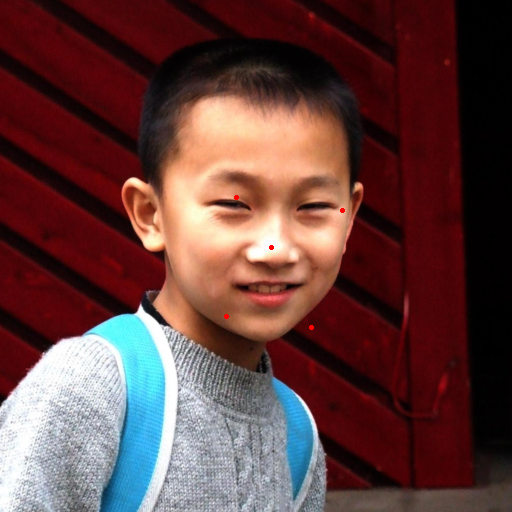

In [77]:
img

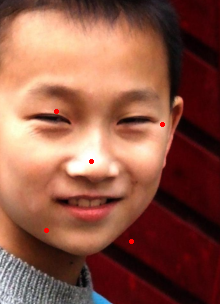

In [78]:
img.crop(boxes.tolist()[0])